## Step 0: Connect to Google drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Step 1: Import modules

In [2]:
import pickle as pc
import os
import numpy as np
import csv
import torch

# torch 버전 확인
print("Pytorch Version: ", torch.__version__)

# GPU 사용 가능 여부
if torch.cuda.is_available():
  device = torch.device('cuda')
  print("There are %d GPU(s) available." % torch.cuda.device_count())
  print("We will use the GPU:", torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead.")
  device = torch.device('cpu')

Pytorch Version:  1.12.1+cu113
There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


## Step 2: Installing the Hugging Face Library

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 67.7 MB/s 
     |████████████████████████████████| 163 kB 87.7 MB/s 


## Step 3: Configure the experiments

* 모델의 실험을 위해 필요한 파라미터 설정
  * Hyperparameter: hidden unit size, vocab size, max length, dropout rate 등
  * Argument: file directory 등

In [4]:
train_filename = '/content/gdrive/My Drive/Colab Notebooks/KT_RNN/data/amazon/bert_train_data_all.csv'
test_data = '/content/gdrive/My Drive/Colab Notebooks/KT_RNN/data/amazon/bert_balanced_data'
test_label = '/content/gdrive/My Drive/Colab Notebooks/KT_RNN/data/amazon/bert_balanced_label'

## Step 4: Load Amazon Review Dataset

* load_data: amazon review data에서 [reviewText, label]형태로 데이터를 불러오기

In [7]:
def load_data(filename):
  data = list()
  label = list()

  f = open(filename, 'r', encoding='utf-8')
  reader = csv.reader(f)
  for idx, line in enumerate(reader):
    if idx == 0:
      continue

    # line[2]에 label 1(긍정), 0(부정) // line[5]에 review text
    data.append(line[5])
    label.append(int(line[2]))

  f.close()

  # data와 label 사이즈 일치 여부 확인
  assert len(data) == len(label)
  return data, label

In [8]:
train_data, train_label = load_data(train_filename)

In [9]:
print("Size of train data: {}".format(len(train_data)))
print("Size of train label: {}".format(len(train_label)))

Size of train data: 10727
Size of train label: 10727


## Step 5: Tokenization & Input Formatting

### Step 5-1: BERT Tokenizer

* BERT에서 사용한 tokenizer를 이용. text -> token 단위
  * 각 token들을 특정 index로 mapping

* BertTokenizer: punctuation split + wordpiece
  * bert-base-uncased: 12 layer, 768 hidden, 12 head, 110M params.
  * uncased: 대문자 -> 소문자 후 tokenize.

In [10]:
from transformers import BertTokenizer

print("Loader BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loader BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# 하나의 sentence에 대해 BertTokenizer 적용

# Print the original sentence.
print("Original: ", train_data[0])
print()

# Print the sentence split into tokens.
print("Tokenized: ", tokenizer.tokenize(train_data[0]))
print()

# Print the sentence mapped to token ids.
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0])))
print()

Original:  I never thought that I would find the right moisturizer for my skin. I have combination skin with large pores that get gunked up if I neglect them and I ve struggled for some time to find a product that would provide sufficient moisture without breaking me out or turning my face into an oil-slick. This is truly a holy grail moisturizer for me and has a nice face feel and natural herbal scent. Will definitely repurchase!  I m a 30 something multi-ethnic muxer and a recent convert to korean beauty. This is my new routine and my skin has never felt or looked bettter!  1) Banila Co Clean It Zero Reservatrol 2) Neogen Green Tea Real Fresh Foam Cleanser 3) MISSHA Time Revolution First Treatment Essence (Morning) or MISSHA Time Revolution Night Repair New Science Ampoule (Night) 4) Cosrx Oil-Free Ultra-Moisturizing Lotion (Morning and ever OTHER night) or Cosrx Ultimate Nourishing Rice Overnight Mask

Tokenized:  ['i', 'never', 'thought', 'that', 'i', 'would', 'find', 'the', 'right

### Step 5-2: Required Formatting

  * Input을 Formatting (입력 3층 만들기)
    * 각 문장의 처음과 끝에 special token 더하기
      * [SEP]: 모든 문장 뒤에 추가
      * [CLS]: 문장의 앞에 추가
    * 각 문장을 max_length만큼 자르고 padding token 채우기
      * 모든 문장들은 하나의 고정된 길이를 지녀야 함
      * max_length보다 긴 문장의 경우 잘라줌
      * max_length보다 작은 경우는 남은 부분을 [PAD] 로 채워줌
        * [PAD]: BERT 사전에서 index0에 해당
        * 여기서 max_len은 512
    * 각 문장에서 padding token과 실제 token을 구분하기 위한 attention masking 적용
      * 토큰이 실제 값인지, [PAD]인지를 구분하는 binary tensor
      * 어텐션 연산을 할 때, 불필요하게 패딩 토큰에 대해 어텐션을 하지 않도록 구분
      * 1은 실제 단어. 마스킹을 하지 않음.
      * 0은 패딩 토큰. 마스킹을 함.

* Sentences to IDs

  * 위 과정들을 한꺼번에 처리
  * word piece들은 내부적으로 할당된 ID가 있음

In [12]:
# Tokenize -> map the tokens & word IDs.
input_ids = []

# For every sentence
for sent in train_data:
  # (1) Tokenize the sentence.
  # (2) [CLS] token to the start
  # (3) [SEP] token to the end
  encoded_sent = tokenizer.encode(sent, add_special_tokens=True, max_length=64)

  # Add the encoded sentence to the list
  input_ids.append(encoded_sent)

# Print train data[0]
print("Original: ", train_data[0])
print()
print("Token IDs: ", input_ids[0])

# Print special tokens and tokenized sentence
print("\n[CLS] token: {:}, ID: {:}".format(tokenizer.cls_token, tokenizer.cls_token_id))
print("\n[PAD] token: {:}, ID: {:}".format(tokenizer.pad_token, tokenizer.pad_token_id))
print("\n[SEP] token: {:}, ID: {:}".format(tokenizer.sep_token, tokenizer.sep_token_id))
print("\nTokenized: ", tokenizer.convert_ids_to_tokens(input_ids[0]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  I never thought that I would find the right moisturizer for my skin. I have combination skin with large pores that get gunked up if I neglect them and I ve struggled for some time to find a product that would provide sufficient moisture without breaking me out or turning my face into an oil-slick. This is truly a holy grail moisturizer for me and has a nice face feel and natural herbal scent. Will definitely repurchase!  I m a 30 something multi-ethnic muxer and a recent convert to korean beauty. This is my new routine and my skin has never felt or looked bettter!  1) Banila Co Clean It Zero Reservatrol 2) Neogen Green Tea Real Fresh Foam Cleanser 3) MISSHA Time Revolution First Treatment Essence (Morning) or MISSHA Time Revolution Night Repair New Science Ampoule (Night) 4) Cosrx Oil-Free Ultra-Moisturizing Lotion (Morning and ever OTHER night) or Cosrx Ultimate Nourishing Rice Overnight Mask

Token IDs:  [101, 1045, 2196, 2245, 2008, 1045, 2052, 2424, 1996, 2157, 11052, 94

In [17]:
len(tokenizer.convert_ids_to_tokens(input_ids[0]))

64

* Padding & Truncating

  * tf.keras.preprocessing.sequence.pad_sequences
    * max_len만큼 padding을 진행

In [18]:
# 입력으로 들어오는 문장의 최대 길이를 지정
print("Max length: ", max([len(each) for each in input_ids]))

Max length:  64


In [19]:
len(input_ids)

10727

In [22]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

MAXLEN = 64

input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAXLEN,
                                                         dtype='long', value=0,
                                                         truncating='post', padding='post')

print("\nPadding is done.")

Tensorflow version: 2.8.2

Padding is done.


In [24]:
# 64로 잘 됨
len(input_ids[0])

64

In [25]:
len(input_ids)

10727

* Attention Masks

In [26]:
# Create attention masks
attention_masks = [] # 각 문장에 대한 attention mask 리스트를 저장

# attention mask 생성
for sent in input_ids: # token id가 10727개 들어있음
  # Create the attention mask.
  att_mask = [int(token_id > 0) for token_id in sent]

  # Store the attention mask for this sentence.
  attention_masks.append(att_mask)
print("\nAttention masking is done.")


Attention masking is done.


* Training & Validation Split

In [29]:
from sklearn.model_selection import train_test_split

# data, labels
train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, train_label, random_state=2022, test_size=0.1)

# masks
train_masks, valid_masks, _, _ = train_test_split(attention_masks, train_label, random_state=2022, test_size=0.1)

# 확인
print(train_inputs[:1])
print(train_masks[:1])

[[  101  1045  1521  1049  1037  3486  1061  3217  4004  2450  2007  4318
   3096  1998  1045  1521  2310  2042  2478  2023 11052  9496  6290  2005
   1016  2706  1006  7237  2058  2013 11382 11106  4877  4415  6149  3512
   7861 23316  1007  1012  2009  8440  1521  1056  3714  2033  2041  1998
   1045  1521  2310  2042  2893 25327  8491 18856  8649  5999 18499  2229
   1012  1045  2572   102]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


* Converting to PyTorch Data Types

In [30]:
# torch.tensor(data) -> tensor
train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

* DataLoader 이용. iterator를 생성.
  * TensorDataset: tensor를 입력받아 dataset 형태로 변환
  * RandomSampler: 입력 dataset에 element들의 index를 무작위로 샘플링
  * SequentialSampler: 입력 dataset에 element들의 index를 순차적으로 샘플링
  * DataLoader: dataset과 sampler를 이용하여 주어진 dataset에 대해 batch size만큼 데이터를 반환

In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# train dataloader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# valid dataloader
valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

## Step 6: Train our classification model

### Step 6-1: BertForSequenceClassification

* pre-trained BERT 모델 위에 single linear layer 하나가 더해진 모델을 불러오기

* 해당 모델을 우리가 원하는 task에 맞게 end-to-end 방식으로 fine-tuning을 진행할 수 있음

* (bert): Embedding 정보
* (encoder): 인코더 정보

In [32]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)

model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [33]:
# Get all of the model's parameters as a list of tuples
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.\n".format(len(params)))
print("=== Embedding Layer ===\n")

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer ====\n")

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== Output Layer====\n")

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

=== Embedding Layer ===

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (76

### Step 6-2: Optimizer & Learning Rate Scheduler

- learning rate scheduler: learning rate를 조절

In [34]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [35]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps = number of batches * number of epochs
print("number of batches:", len(train_dataloader))
total_steps = len(train_dataloader) * epochs

print("total_steps:", total_steps)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

number of batches: 302
total_steps: 1208


### Step 6-3: Training Loop

* DataLoader를 통해 data와 label을 batch 단위로 가져오기
* Forward pass: data와 label을 모델에 입력으로 주기
* Backward pass:
  * minibatch gradient 계산 (backpropagation)
  * 모델의 파라미터 업데이트 (optimization)

In [36]:
# Function to calculate the accuracy of predictions vs labels

def flat_accuracy(preds, labels):
  # argmax: 해당 axis의 값 중에서 가장 큰 값의 인덱스를 반환
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [37]:
import time
import datetime

# Take a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
  # Round to the nearest second
  elapsed_rounded = int(round(elapsed))

  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [38]:
import random

# Set the seed value
def set_seed(seed_val):
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

In [39]:
seed_val = 42
set_seed(seed_val)

# Store the average loss after each epoch
loss_values = []

# Epoch
for epoch in range(0, epochs):
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set
    print("")
    print("======= Epoch {:} / {:} =======".format(epoch + 1, epochs))
    print("Training...")

    # Measure how long the epoch takes
    t0 = time.time()

    # Reset the total loss
    total_loss = 0.

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
      # Progress update every 40 batches
      if step % 40 == 0 and not step == 0:

        # Calculate elapsed time in minutes
        elapsed = format_time(time.time() - t0)

        # Report progress
        print("Batch {:>5,} of {:>5,}. Elapsed: {:}.".format(step, len(train_dataloader), elapsed))

      # Unpack this training batch from our dataloader
      # [0] : input ids
      # [1] : attention masks
      # [2] : labels
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      # Clear gradients before performing a backward pass
      model.zero_grad()

      # Forward Pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

      # model returns a tuple
      # need to pull the loss value out of the tuple
      loss = outputs[0]

      # Accumulate the training loss
      total_loss += loss.item()

      # Backward Pass
      loss.backward()

      # Clip the norm of the gradients to 1.0
      # Prevent the exploding gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and take a step
      optimizer.step()

      # Update the lr
      scheduler.step()

    # Calculate the average loss over the train data
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve
    loss_values.append(avg_train_loss)

    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    # measure our performance on the valid set
    print("")
    print("Running Validation...")

    t0 = time.time()

    # model in evaluation mode
    model.eval()

    # Tracking variables
    eval_loss, eval_acc = 0., 0.

    # Evaluate data for one epoch
    for valid_step, batch in enumerate(valid_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
        # Forward pass, calculate logit pred
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      # Get the logits output by the model
      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate the accuracy for this batch of test sentences
      tmp_eval_acc = flat_accuracy(logits, label_ids)

      # Accumulate the total accuracy
      eval_acc += tmp_eval_acc

    # Report the final accuracy for validation
    print("Accuracy: {0:.2f}".format(eval_acc / (valid_step + 1)))
    print("Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")    


======= Epoch 1 / 4 =======
Training...
Batch    40 of   302. Elapsed: 0:00:07.
Batch    80 of   302. Elapsed: 0:00:10.
Batch   120 of   302. Elapsed: 0:00:14.
Batch   160 of   302. Elapsed: 0:00:18.
Batch   200 of   302. Elapsed: 0:00:22.
Batch   240 of   302. Elapsed: 0:00:25.
Batch   280 of   302. Elapsed: 0:00:29.

Average training loss: 0.18
Training epoch took: 0:00:31

Running Validation...
Accuracy: 0.97
Validation took: 0:00:01

======= Epoch 2 / 4 =======
Training...
Batch    40 of   302. Elapsed: 0:00:04.
Batch    80 of   302. Elapsed: 0:00:07.
Batch   120 of   302. Elapsed: 0:00:11.
Batch   160 of   302. Elapsed: 0:00:15.
Batch   200 of   302. Elapsed: 0:00:19.
Batch   240 of   302. Elapsed: 0:00:22.
Batch   280 of   302. Elapsed: 0:00:26.

Average training loss: 0.06
Training epoch took: 0:00:28

Running Validation...
Accuracy: 0.97
Validation took: 0:00:01

======= Epoch 3 / 4 =======
Training...
Batch    40 of   302. Elapsed: 0:00:04.
Batch    80 of   302. Elapsed: 0:00

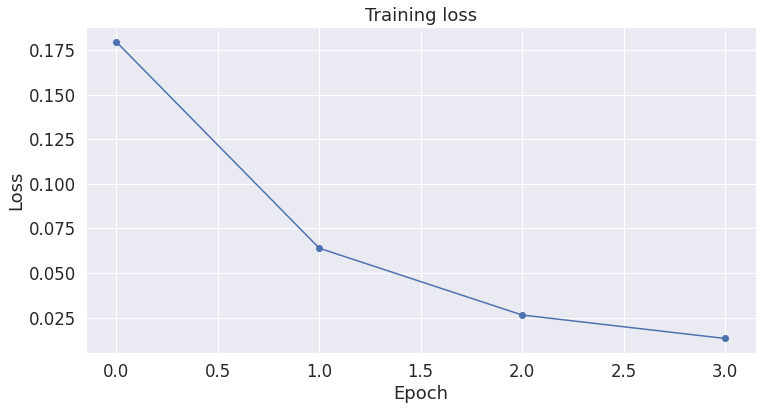

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12, 6)

# Plot the learning curve
plt.plot(loss_values, 'b-o')

# Label the plot
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Step 7: Performance on Test set

### Step 7-1: Load Amazon Review Test Dataset

In [43]:
# pickle 모듈로 테스트 파일을 load
with open(test_data, 'rb') as f:
  test_data = pc.load(f)
with open(test_label, 'rb') as f:
  test_label = pc.load(f)


print("Size of test data: {}".format(len(test_data)))
print("Size of test label: {}".format(len(test_label)))

Size of test data: 174
Size of test label: 174


### Step 7-2: Tokenization & Input Formatting

* BERT 모델의 입력 format에 맞게 test data를 변환

In [44]:
input_ids = []

for sent in test_data:
  encoded_sent = tokenizer.encode(sent, add_special_tokens=True)
  input_ids.append(encoded_sent)

# Pad input tokens
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAXLEN,
                                                          dtype='long', truncating='post', padding='post')

# attention masks
attention_masks = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]
  attention_masks.append(att_mask)

# Convert to tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_label)

batch_size = 32

# DataLoader
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data) 
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Step 7-3: Evaluate on Test Set

In [45]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader (batch에서 데이터 추출)
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      
  logits = outputs[0]

  # Move logits and labels to CPU

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  # predictions : 예측값 array
  # true_labels : 정답값 array
  # logits array의 값들 중 가장 큰 값의 index를 반환
  # when axis = 1, argmax identifies the maximum value for every row. 
  predictions.extend(np.argmax(logits, axis=1).flatten()) # [0, 1, 1, 0, ...]
  true_labels.extend(label_ids.flatten()) # [0, 1, 0, 0, ...]

print('DONE.')

Predicting labels for 174 test sentences...
DONE.


In [46]:
# accuracy, precision, recall, f1 score 성능 확인
from sklearn.metrics import classification_report
    
target_names = ['negative', 'positive']

print(classification_report(true_labels, predictions, digits=4, target_names=target_names))

              precision    recall  f1-score   support

    negative     0.9467    0.8161    0.8765        87
    positive     0.8384    0.9540    0.8925        87

    accuracy                         0.8851       174
   macro avg     0.8925    0.8851    0.8845       174
weighted avg     0.8925    0.8851    0.8845       174

